In [1]:
import mistat
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
import pgmpy
pgmpy.__version__

'0.1.22'

In [3]:
from pgmpy.estimators import HillClimbSearch, MmhcEstimator, PC

bioreactor = pd.read_csv('Bioreactors run051207.csv')
# Rename a few of the column names to avoid problems with the graph representation
mapping = {name: name.split('(')[0].replace('%', '').replace('/', '_').strip('_').replace('#', 'nr') 
           for name in bioreactor.columns}
bioreactor = bioreactor.rename(columns=mapping)
print(bioreactor.columns)



Index(['Days', 'Aspartic_acid', 'Threonine', 'Serine', 'Glutamic_acid',
       'Glutamine', 'Proline', 'Glycine', 'Alanine', 'Valine', 'Methionine',
       'Isoleucine', 'Leucine', 'Tyrosine', 'Phenylalanine', 'Lysine',
       'Histidine', 'Arginine', 'Bioreactor_nr', 'IGF', 'Amino_acids',
       'Ps_PCD', 'Titer_mg_L', 'Max_Titer', 'Max_prod', 'Max_prod_cells',
       'miu', 'deamid', 'Tit_Max', 'Max_Volumetric_productivity', 'Max_cells'],
      dtype='object')


Define a function to visualize the Bayesian network graph

In [4]:
import graphviz
from tempfile import TemporaryDirectory
from IPython.display import Image

def layoutGraph(dot_data, pdfFile=None):
    graph = graphviz.Source(dot_data)
    with TemporaryDirectory() as tempdir:
        if pdfFile is not None:
            graph.render('dot', directory=tempdir, format='pdf', outfile=pdfFile)
        return Image(graph.render('dot', directory=tempdir, format='png'))

def createGraph(G, pdfFile=None):
    sortedNodes = list(nx.topological_sort(G))
    commonSettings = """
    edge [ fontsize=11, color=gray55 ];
    # size="10,10"
    graph [ranksep="0.2", dpi=300];
    """
    def makeNode(label):
        return f'{label} [ label="{label}", fontsize=11, color=white ];'
    def makeEdge(edge):
        fromNode, toNode = edge
        return f'{fromNode} -> {toNode};'

    allNodes = '\n'.join(makeNode(node) for node in sortedNodes)
    allEdges = '\n'.join(makeEdge(edge) for edge in G.edges)

    s = f"""
    digraph network {{
    { commonSettings }
    { allNodes }
    { allEdges }
     }}
     """
    return layoutGraph(s, pdfFile)

Derive a Bayesian network from the data

  0%|          | 0/130 [00:00<?, ?it/s]

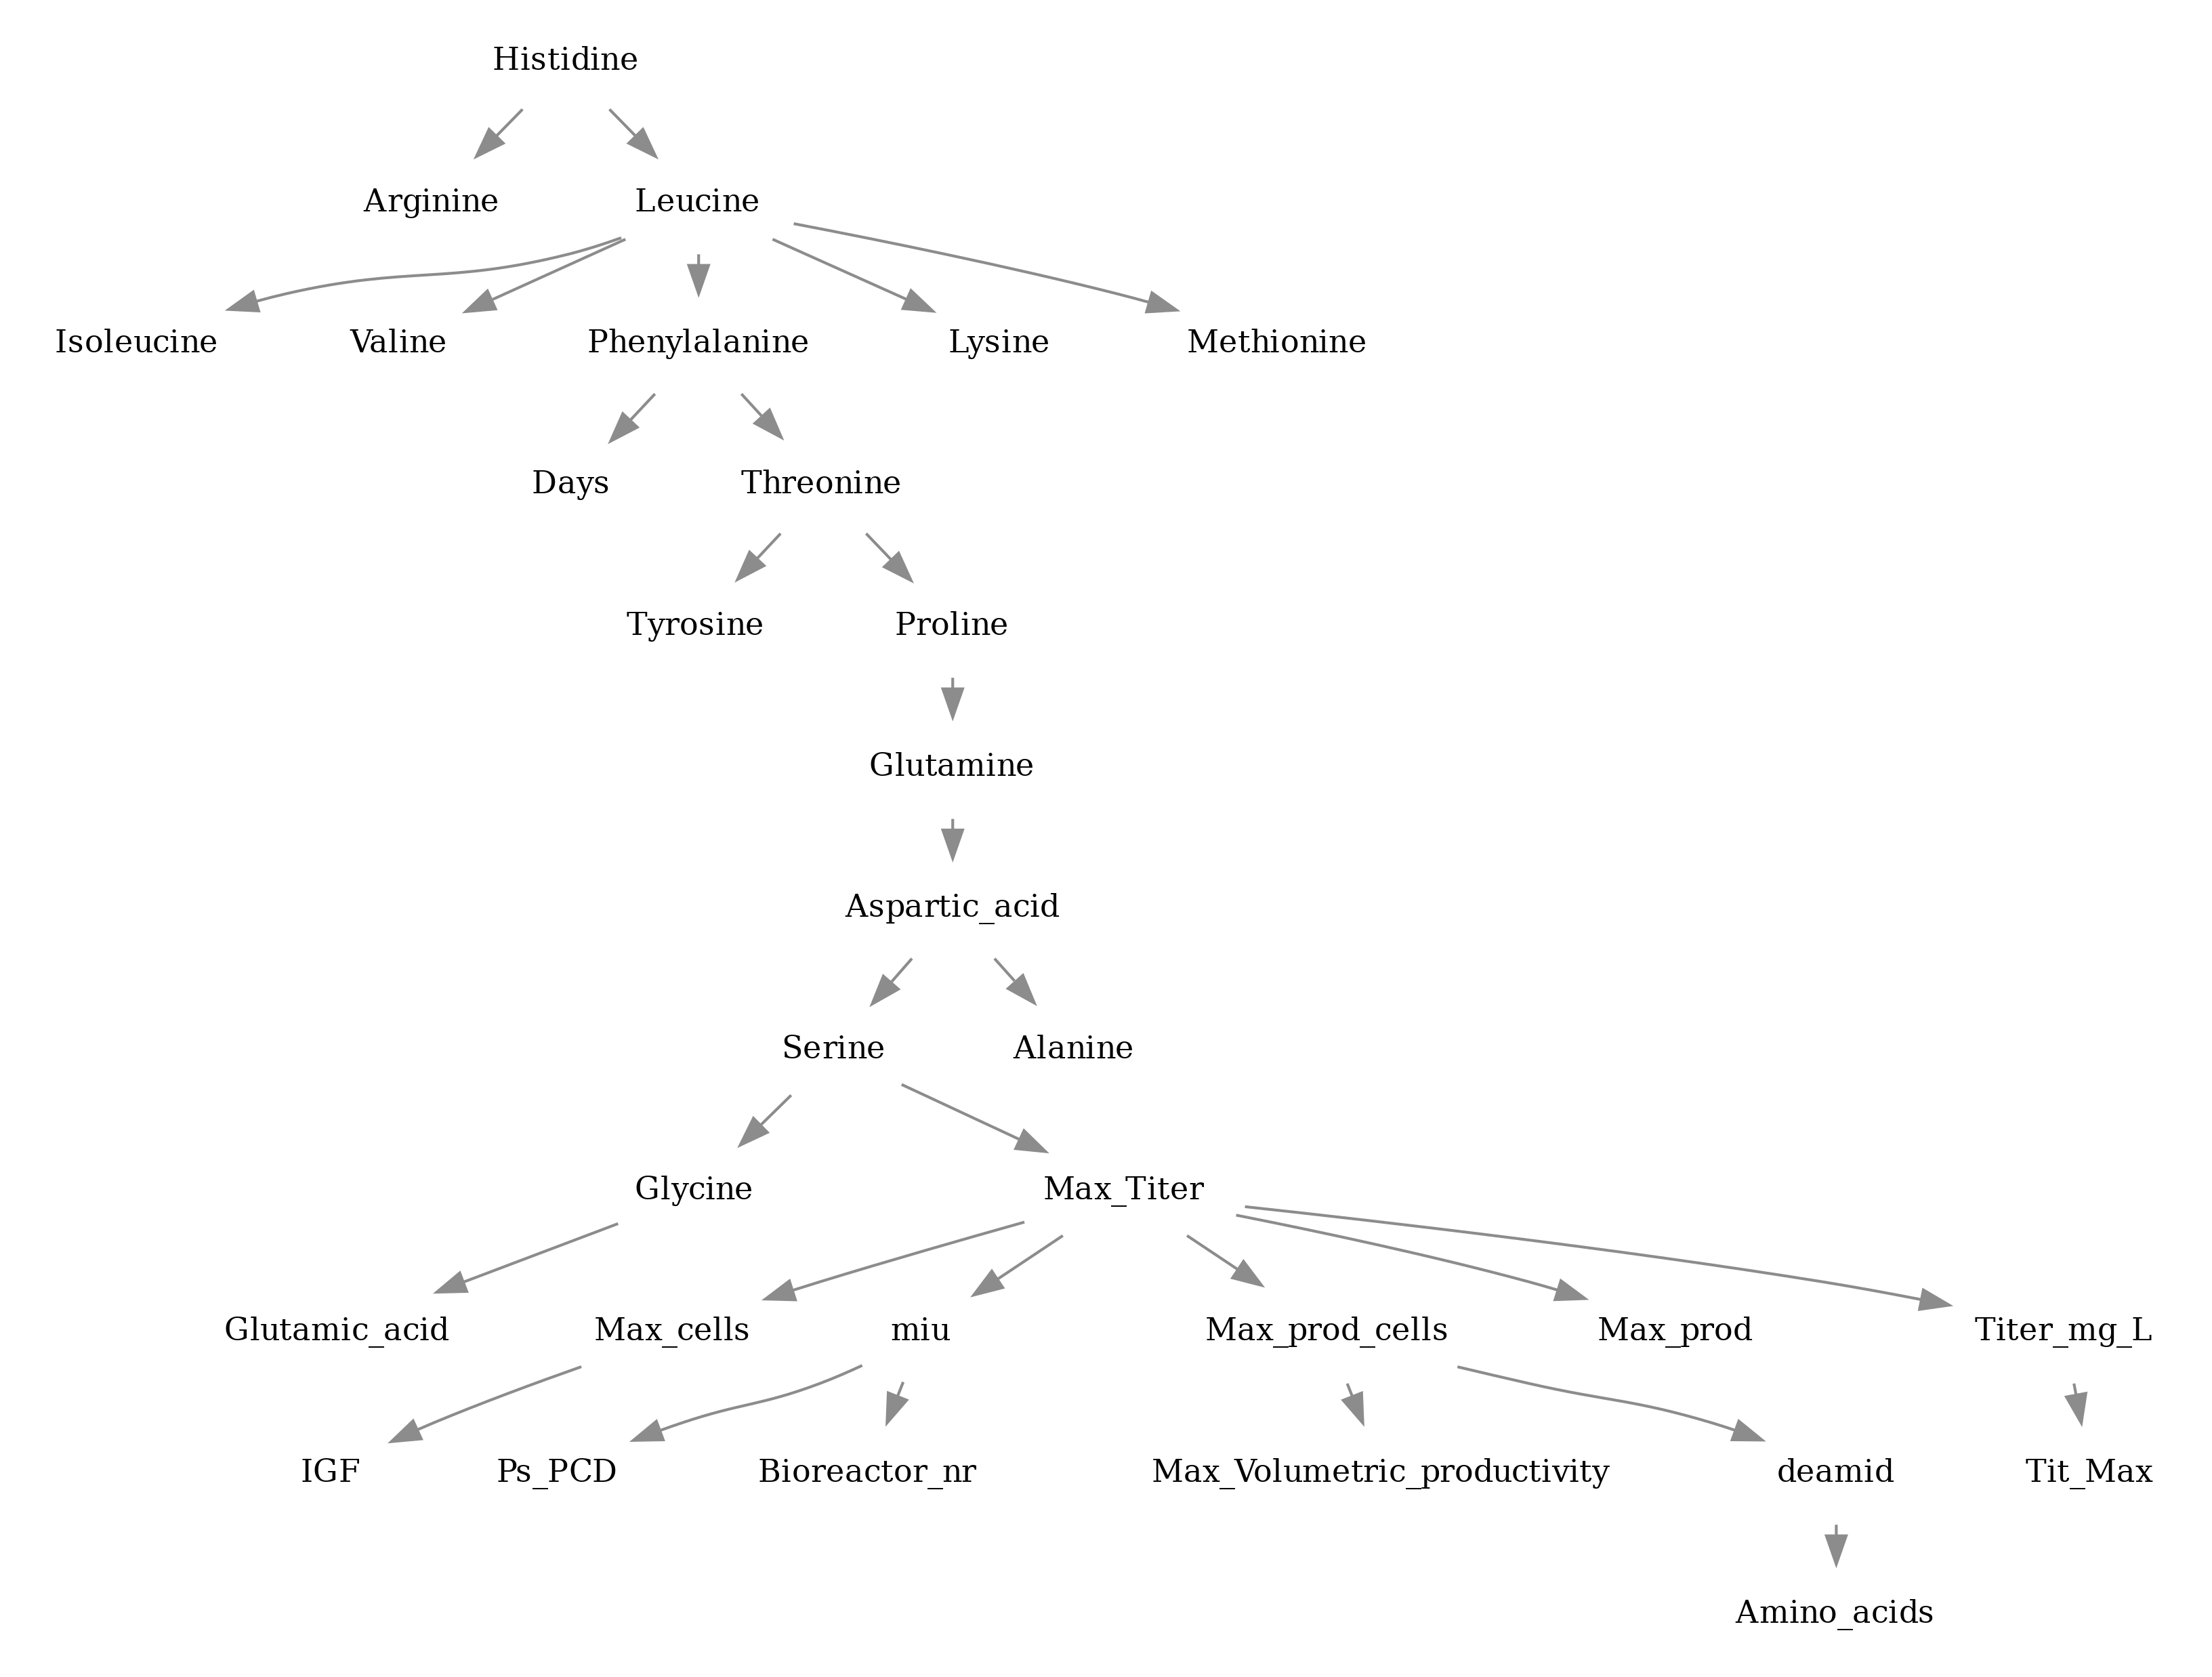

In [5]:
est = HillClimbSearch(data=bioreactor)
model = est.estimate(max_iter=130, show_progress=True, epsilon=1e-6,
                     scoring_method='bdsscore')
# model = est.estimate(max_iter=130, show_progress=True, epsilon=1e-6,
#                      scoring_method='k2score')
createGraph(model)

In [6]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator, ExpectationMaximization

# convert to BayesianNetwork and fit data
model = BayesianNetwork(model.edges())
# model.fit(data=bioreactor, estimator=MaximumLikelihoodEstimator)
model.fit(data=bioreactor, estimator=BayesianEstimator)
# model.fit(data=bioreactor, estimator=ExpectationMaximization)

In [7]:
for cpd in model.get_cpds():
    df = pd.DataFrame(cpd.values)
    v0 = cpd.variables[0]
    df.index = pd.MultiIndex.from_tuples([(v0, state) for state in cpd.state_names[v0]])
    if len(cpd.variables) > 1:
        v1 = cpd.variables[1]
        df.columns = pd.MultiIndex.from_tuples([(v1, state) for state in cpd.state_names[v1]])
    print(df.round(3))
    break

                   Glutamine                                                   \
                        0.00   0.33   0.39   0.52   0.79   0.80   0.82   1.03   
Aspartic_acid 0.57     0.913  0.023  0.023  0.023  0.023  0.023  0.023  0.023   
              0.70     0.007  0.023  0.023  0.023  0.023  0.023  0.023  0.023   
              0.71     0.007  0.023  0.023  0.023  0.023  0.023  0.023  0.729   
              0.75     0.007  0.023  0.023  0.023  0.023  0.023  0.729  0.023   
              0.76     0.007  0.023  0.023  0.023  0.729  0.023  0.023  0.023   
              0.82     0.007  0.023  0.023  0.023  0.023  0.023  0.023  0.023   
              0.84     0.007  0.023  0.023  0.023  0.023  0.023  0.023  0.023   
              0.91     0.007  0.023  0.023  0.023  0.023  0.023  0.023  0.023   
              0.93     0.007  0.023  0.023  0.023  0.023  0.023  0.023  0.023   
              1.41     0.007  0.729  0.023  0.023  0.023  0.023  0.023  0.023   
              1.47     0.007

In [9]:
from pgmpy.inference import BeliefPropagation
infer = BeliefPropagation(model)

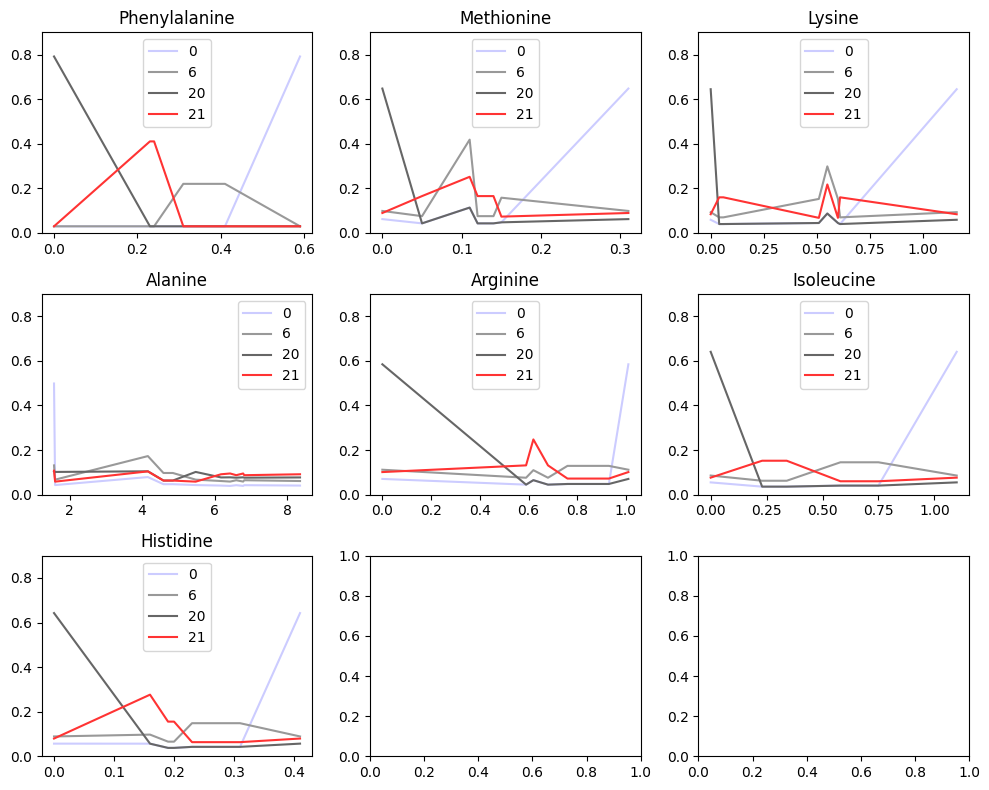

In [10]:
import itertools
import gc
gc.collect()
evidence = 'Days'
evidence_states = sorted(bioreactor[evidence].unique())

outcomes = ['Phenylalanine', 'Methionine', 'Lysine', 'Alanine',
            'Arginine', 'Isoleucine', 'Histidine']
fig, axes = plt.subplots(figsize=[10, 8], ncols=3, nrows=3)

cmap = plt.get_cmap("gray")
n = len(evidence_states) + 1
colors = [cmap(i/n) for i in reversed(range(1, n))]
colors[0] = (0.8, 0.8, 1.0, 1.0)
colors[-1] = (1.0, 0.2, 0.2, 1.0)


for ax, outcome in zip(itertools.chain(*axes), outcomes):
    results = {i: infer.query(variables=[outcome], evidence={evidence: i}).values
               for i in evidence_states}
    outcome_states = sorted(bioreactor[outcome].unique())
    df = pd.DataFrame(results, index=outcome_states)
    df.plot(ax=ax, color=colors)
    ax.set_title(outcome)
    ax.set_ylim(0, 0.9)
    gc.collect()
plt.tight_layout()
plt.show()


In [11]:
import gc
gc.collect()

7